<ipython-input-2-14a448312914>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x="Cluster", y="AvgTotalSpending", palette="viridis")


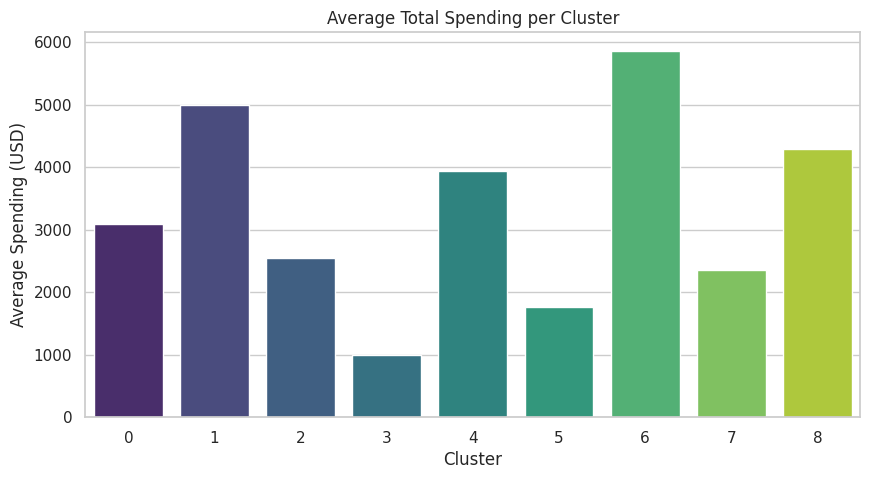

<ipython-input-2-14a448312914>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x="Cluster", y="AvgTransactionCount", palette="coolwarm")


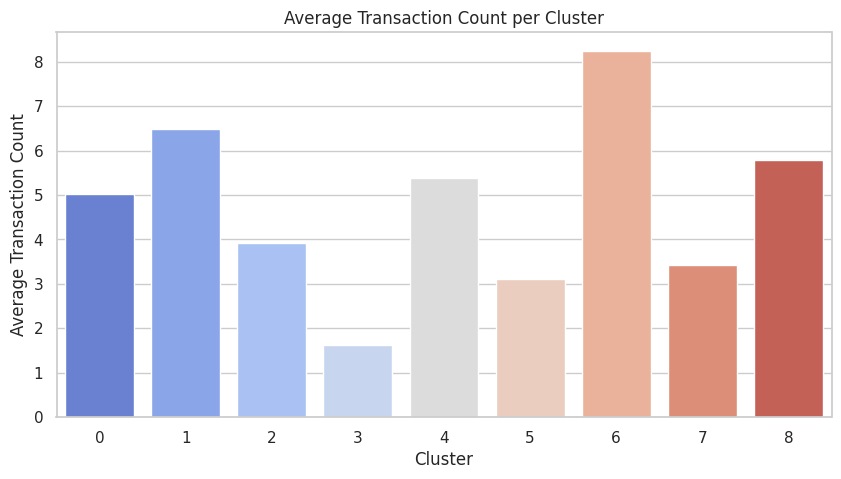

<ipython-input-2-14a448312914>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x="Cluster", y="AvgRecency", palette="magma")


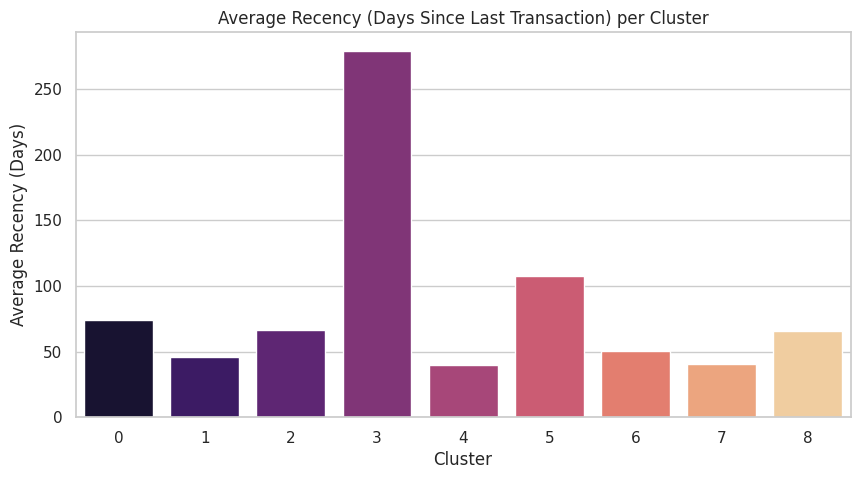

Optimal Number of Clusters: 9
Davies-Bouldin Index: 1.1392928349171103


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Merge transactions with products and customers
tx_merged = transactions_df.merge(products_df, on="ProductID", how="left")
tx_merged = tx_merged.merge(customers_df, on="CustomerID", how="left")

# Convert date columns to datetime format
tx_merged["TransactionDate"] = pd.to_datetime(tx_merged["TransactionDate"])
tx_merged["SignupDate"] = pd.to_datetime(tx_merged["SignupDate"], errors='coerce')

# Feature Engineering
latest_date = tx_merged["TransactionDate"].max()

# Compute customer behavior metrics
customer_spending = tx_merged.groupby("CustomerID")["TotalValue"].sum().reset_index()
customer_spending.rename(columns={"TotalValue": "TotalSpending"}, inplace=True)

customer_frequency = tx_merged.groupby("CustomerID")["TransactionID"].count().reset_index()
customer_frequency.rename(columns={"TransactionID": "TransactionCount"}, inplace=True)

customer_recency = tx_merged.groupby("CustomerID")["TransactionDate"].max().reset_index()
customer_recency["Recency"] = (latest_date - customer_recency["TransactionDate"]).dt.days
customer_recency.drop(columns=["TransactionDate"], inplace=True)

# Merge all features
customer_features = customers_df.merge(customer_spending, on="CustomerID", how="left")
customer_features = customer_features.merge(customer_frequency, on="CustomerID", how="left")
customer_features = customer_features.merge(customer_recency, on="CustomerID", how="left")

# One-Hot Encoding for Region
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

# Days Since Signup
# Ensure 'SignupDate' column is of datetime type before calculation
customer_features["SignupDate"] = pd.to_datetime(customer_features["SignupDate"], errors='coerce')  # Force datetime conversion, handling errors
customer_features["SignupDays"] = (latest_date - customer_features["SignupDate"]).dt.days
customer_features.drop(columns=["SignupDate"], inplace=True)

# Fill missing values
customer_features.fillna(0, inplace=True)

# Standardize Features
scaler = StandardScaler()
clustering_features = customer_features.drop(columns=["CustomerID", "CustomerName"])
scaled_features = scaler.fit_transform(clustering_features)

# Find optimal K using Davies-Bouldin Index
best_k, best_db_index = None, np.inf
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    if db_index < best_db_index:
        best_k, best_db_index = k, db_index

# Apply K-Means Clustering with best K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans.fit_predict(scaled_features)

# Cluster Profiling
cluster_summary = customer_features.groupby("Cluster").agg({
    "TotalSpending": ["mean", "median"],
    "TransactionCount": ["mean", "median"],
    "Recency": ["mean", "median"],
    "SignupDays": ["mean", "median"]
}).reset_index()

# Rename columns for readability
cluster_summary.columns = ["Cluster", "AvgTotalSpending", "MedTotalSpending",
                           "AvgTransactionCount", "MedTransactionCount",
                           "AvgRecency", "MedRecency",
                           "AvgSignupDays", "MedSignupDays"]

# Visualization
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(data=cluster_summary, x="Cluster", y="AvgTotalSpending", palette="viridis")
plt.title("Average Total Spending per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spending (USD)")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=cluster_summary, x="Cluster", y="AvgTransactionCount", palette="coolwarm")
plt.title("Average Transaction Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Transaction Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=cluster_summary, x="Cluster", y="AvgRecency", palette="magma")
plt.title("Average Recency (Days Since Last Transaction) per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Recency (Days)")
plt.show()

# Print the best number of clusters and DB index
print(f"Optimal Number of Clusters: {best_k}")
print(f"Davies-Bouldin Index: {best_db_index}")